# Advanced Information Retrieval - Project

### Organizational infos:
* 30 Points in total
* Deadline: 09.01.2023 23:59

In [51]:
#imports

import pandas as pd
import numpy as np
import random
import ast
import gensim
from torch import nn
from math import sqrt
import torch
from nltk.tokenize import WhitespaceTokenizer
from collections import defaultdict
from scipy.stats import pearsonr
from thefuzz import fuzz
from thefuzz import process

## Movie struct
Create a struct that contains all  the movie relevant Information to work with.
Could be changed at any given time.


**Define all relevante class attributes**

In [2]:
class Movie:
    def __init__(self, id, name, genres):
        self.id = id
        self.name = name
        self.genres = genres
        self.tagsRelevance = [0] * 1128
        self.tagsList = []
        self.ratingCount = 0
        self.ratingSum = 0
        self.rating = 0

    def SetTagRelevanceVector(self, tagsRelevance):
        self.tagsRelevance = tagsRelevance

    def SetTagsList(self, tagsList):
        self.tagsList = tagsList
    
    def SetSumRatings(self, userRatings):
        self.rating = userRatings
    
    def AddRatingCount(self, userRating):
        self.ratingCount += 1
        self.ratingSum += userRating
        self.rating = self.ratingSum / self.ratingCount
    

**Create A List of Movies and a look up Table for the Genres for later usage.**

The Genres could also be used for a similarity measurement so i just saved the just in case.
Also i am not to sure if genre-14 (Imax) should really be inluded. 

In [3]:

def CreateMovieList(lookUpGenre):
    allMovies = {}
    moviedocs = pd.read_csv('movies.csv')
    lookUpIndex = 1

    for i in range(len(moviedocs)):
        movieGenres = moviedocs['genres'][i]
        movieGenresList = movieGenres.split('|')
        movieGenresNumericalList = []
        for word in movieGenresList:
            if word not in lookUpGenre:
                lookUpGenre[word] = lookUpIndex
                lookUpIndex += 1

            movieGenresNumericalList.append(lookUpGenre[word])
        movie = Movie(moviedocs['movieId'][i], moviedocs['title'][i], movieGenresNumericalList)

        allMovies[movie.id] = movie
    return allMovies
    

**Adds the Genom Score relevances to the Movies**

The genom score is the relevances the tags have to the movies. We also have a csv file mapping the tags to an index.
So i created a tags look up table.

In [4]:
def CreateTagsLookUpTable():
    genres = pd.read_csv('genome-tags.csv')
    tagsLookUpTable = {}
    for index in range(len(genres)):
        tagsLookUpTable[genres['tagId'][index]] = genres['tag'][index]
        index += 1
    return tagsLookUpTable

tags_lookup_table = CreateTagsLookUpTable()


def AddGenoScoresToMovies(movieList):
    genomeScores = pd.read_csv('genome-scores.csv')
    movieTagsRelevance = []
    tags = []
    movieId = genomeScores['movieId'][0]
    for i in range(len(genomeScores)):
        if genomeScores['movieId'][i] != movieId:
            movieList[movieId].SetTagRelevanceVector(movieTagsRelevance.copy())
            movieList[movieId].SetTagsList(tags.copy())
            movieId = genomeScores['movieId'][i]
            movieTagsRelevance.clear()
            tags.clear()

        tags.append(tags_lookup_table[genomeScores["tagId"][i]])
        movieTagsRelevance.append(genomeScores['relevance'][i])
    movieList[movieId].SetTagRelevanceVector(movieTagsRelevance)
    return


genomeScores = pd.read_csv('genome-scores.csv')
print(genomeScores['movieId'][0])
print(genomeScores['relevance'][0])

1
0.0287499999999999


**Using all the Functions above**


well it's not takes a lot of time to add all the relevance scores...

In [5]:
lookUpTableGenres = {}
movies = CreateMovieList(lookUpTableGenres)
AddGenoScoresToMovies(movies)
lookUpTags = CreateTagsLookUpTable()


**Use the tags as a similarity measurement vector.**

Get a sorted List with a given size depending on the count. Uses the Cosine similiarity or Jaccard similarity to calculate the tags similarity between movies.

In [6]:

def calc_cosine(movieOne, movieTwo):

    d_1 = 0
    d_2 = 0
    numerator = 0
    for index in range(len(movieOne)):
        numerator += movieOne[index] * movieTwo[index]
        d_1 += movieOne[index] * movieOne[index]
        d_2 += movieTwo[index] * movieTwo[index]

    denominator = np.sqrt(d_1) * np.sqrt(d_2)
    res = numerator / denominator
    return res


def jaccard_sim(movie1,movie2):
    number_both=set(movie1).intersection(set(movie2))
    number_oberservations_in_either = len(movie1)+len(movie2)-len(number_both)
    similarity= float(len(number_both)) / number_oberservations_in_either
    return similarity


def GetTopTagsCosineSims(count, movies, query):

    #empty
    if query.tagsRelevance.count(0) == 1128:
        return -1
        
    smiliarMovies = {}
    simValues = []
    for mID in movies:
        if movies[mID].name == query.name or movies[mID].tagsRelevance.count(0) == 1128:
            continue
        sim = calc_cosine(movies[mID].tagsRelevance, query.tagsRelevance)
        simValues.append(sim)
        smiliarMovies[sim] = movies[mID].name

    TopSimilar = {}


    for i in range(count):
        v = max(simValues)
        TopSimilar[v] = smiliarMovies[v]
        simValues.remove(v)
    return TopSimilar

def get_top_tags_jaccard_sims(count, movies, query):

    if query.tagsRelevance.count(0) == 1128:
        return -1

    smiliar_movies = {}
    sim_values = []
    for mID in movies:
        if movies[mID].name == query.name or movies[mID].tagsRelevance.count(0) == 1128:
            continue
        sim = jaccard_sim(movies[mID].tagsRelevance, query.tagsRelevance)
        sim_values.append(sim)
        smiliar_movies[sim] = movies[mID].name

    top_similar = {}

    sim_values.sort(reverse=True)

    for i in range(count):
        top_similar[sim_values[i]] = smiliar_movies[sim_values[i]]
    return top_similar


def PrintSimilarity(similarMovies):
    if similarMovies != -1:
        #print("Query: ", query.name)
        print("similar Movies: ")
        count = 1
        for sim in similarMovies:
            print(count, similarMovies[sim] + ":", sim)
            count += 1
    else:
        print("Query deosn't have tags!")


['007', '007 (series)', '18th century', '1920s', '1930s', '1950s', '1960s', '1970s', '1980s', '19th century', '3d', '70mm', '80s', '9/11', 'aardman', 'aardman studios', 'abortion', 'absurd', 'action', 'action packed', 'adaptation', 'adapted from:book', 'adapted from:comic', 'adapted from:game', 'addiction', 'adolescence', 'adoption', 'adultery', 'adventure', 'affectionate', 'afi 100', 'afi 100 (laughs)', 'afi 100 (movie quotes)', 'africa', 'afterlife', 'aging', 'aids', 'airplane', 'airport', 'alaska', 'alcatraz', 'alcoholism', 'alien', 'alien invasion', 'aliens', 'allegory', 'almodovar', 'alone in the world', 'alter ego', 'alternate endings', 'alternate history', 'alternate reality', 'alternate universe', 'amazing cinematography', 'amazing photography', 'american civil war', 'amnesia', 'amy smart', 'android(s)/cyborg(s)', 'androids', 'animal movie', 'animals', 'animated', 'animation', 'anime', 'antarctica', 'anti-hero', 'anti-semitism', 'anti-war', 'apocalypse', 'archaeology', 'argenti

Get a sorted List with a given size depending on the count. Uses the Pearson Correlation Coefficient to calculate the tags similarity between movies.

In [7]:
def calcPearsonCoefficient(movie, query):
    correlation, _ = pearsonr(movie, query)
    return correlation

def GetTopTagsPearsonCorrelation(count, movies, query):

    if query.tagsRelevance.count(0) == 1128:
        return -1

    similarity = dict()
    for mID in movies:
        if movies[mID].name == query.name or movies[mID].tagsRelevance.count(0) == 1128:
            continue
        sim = calcPearsonCoefficient(movies[mID].tagsRelevance, query.tagsRelevance)
        similarity[movies[mID].name] = sim

    top_movies = dict()
    for key in sorted(similarity, key=similarity.get, reverse=True)[:count]:
        top_movies[key] = similarity[key]

    return top_movies

def PrintPearsonCorrelation(similarMovies):
    if similarMovies != -1:
        print("\nQuery: ", query.name)
        print("similar Movies according to Pearson Correlation Coefficient: ")
        for idx, movie_key in enumerate(similarMovies):
            print(idx + 1, str(movie_key) + " : " + str(similarMovies[movie_key]))
    else:
        print("Query deosn't have tags!")

Get a sorted List with a given size depending on the count. Uses the Euclidean Distance to calculate the tags similarity between movies.

In [33]:
def euclidean_distance(listOne, listTwo):
  distance = 0
  for i in range(len(listOne)):
    distance += (listOne[i] - listTwo[i]) ** 2
  
  return sqrt(distance)

def euclidean_distance_tags(movieOne, movieTwo):
  tagrelevances = 0
  for i in range(len(movieOne.tagsRelevance)):
    tagrelevances += (movieOne.tagsRelevance[i] - movieTwo.tagsRelevance[i]) ** 2
  
  return sqrt(tagrelevances);

def GetTopTagsEuclideanDistance(count, movies, query):
  if query.tagsRelevance.count(0) == 1128:
    return -1
  
  smiliar_movies = {}

  for otherMovieId in movies:
    if (otherMovieId == query.id or movies[otherMovieId].tagsRelevance.count(0) == 1128):
      continue
    
    sim = euclidean_distance_tags(movies[otherMovieId], query)
    smiliar_movies[movies[otherMovieId].name] = sim

  sortedMovies = sorted(smiliar_movies.items(), key=lambda x: x[1])
  
  return sortedMovies[:count]

def PrintEuclideanDistanceMovies(similarMovies):
  if similarMovies != -1:
      print("\nQuery: ", query.name)
      print("similar Movies according to Euclidean Distance: ")
      for idx, movie_key in enumerate(similarMovies):
          print(idx + 1, str(movie_key) + " : ")
  else:
      print("Query deosn't have tags!")

**Create a query and get/prints the movies with similar tags**

Uses the functions above to print the query result.

In [36]:
query = movies[4896]
count = 10

similarMovies = GetTopTagsCosineSims(count, movies, query)
PrintSimilarity(similarMovies)

similar_movies_with_jaccard = get_top_tags_jaccard_sims(count, movies, query)
PrintSimilarity(similar_movies_with_jaccard)

similarPearsonMovies = GetTopTagsPearsonCorrelation(count, movies, query)
PrintPearsonCorrelation(similarPearsonMovies)

similarEuclideanDistanceMovies = GetTopTagsEuclideanDistance(count, movies, query)
PrintEuclideanDistanceMovies(similarEuclideanDistanceMovies)

similar Movies: 
1 Harry Potter and the Chamber of Secrets (2002): 0.977978451828736
2 Harry Potter and the Goblet of Fire (2005): 0.9697791461817978
3 Harry Potter and the Prisoner of Azkaban (2004): 0.9688240598617508
4 Harry Potter and the Order of the Phoenix (2007): 0.9637341256626571
5 Harry Potter and the Deathly Hallows: Part 1 (2010): 0.9437881725876737
6 Harry Potter and the Half-Blood Prince (2009): 0.9437512850141854
7 Harry Potter and the Deathly Hallows: Part 2 (2011): 0.9359784057024187
8 Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005): 0.8976148003424176
9 Spiderwick Chronicles, The (2008): 0.8844944457999436
10 Chronicles of Narnia: Prince Caspian, The (2008): 0.8802772014082358
similar Movies: 
1 Bird Box (2018): 0.2
2 The Hustle (2019): 0.19936204146730463
3 A Wrinkle in Time (2018): 0.19872476089266738
4 Summer of 84 (2018): 0.1980881571959639
5 Death Note Rewrite: Genshisuru Kami (2007): 0.19745222929936307
6 Murder on the Orient Express (201

#Plotting


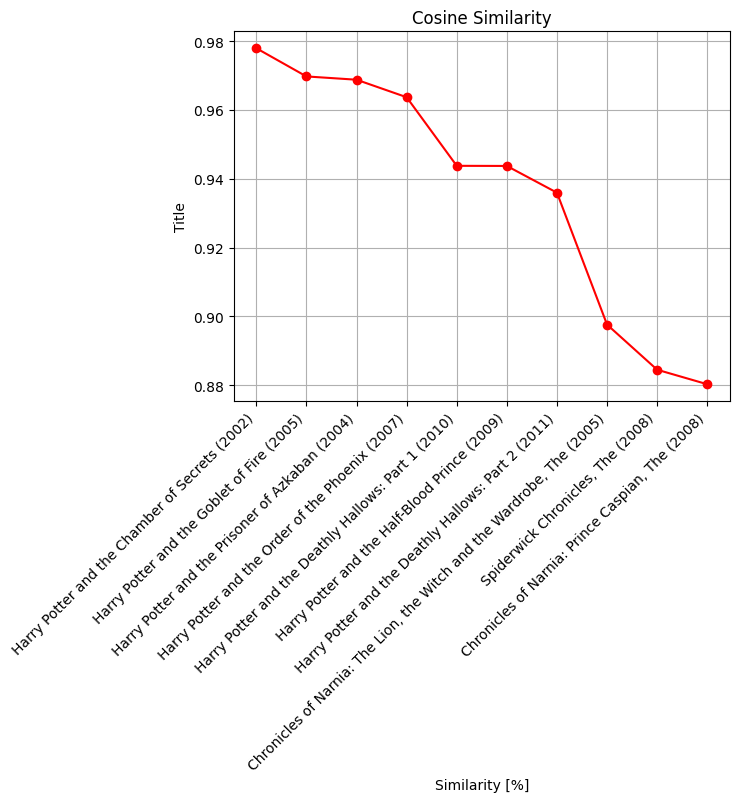

In [46]:
def GetPlotData(similarMovies):
  similarities = []
  names = []
  for name, similarity in similarMovies:
      names.append(name)
      similarities.append(similarity)

  return (names, similarities)

#cosine similarity
similarMovies = GetTopTagsCosineSims(count, movies, query)
similarities = GetPlotData(similarMovies.items())

plt.grid()
plt.plot(similarities[1], similarities[0], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Cosine Similarity")
plt.show()

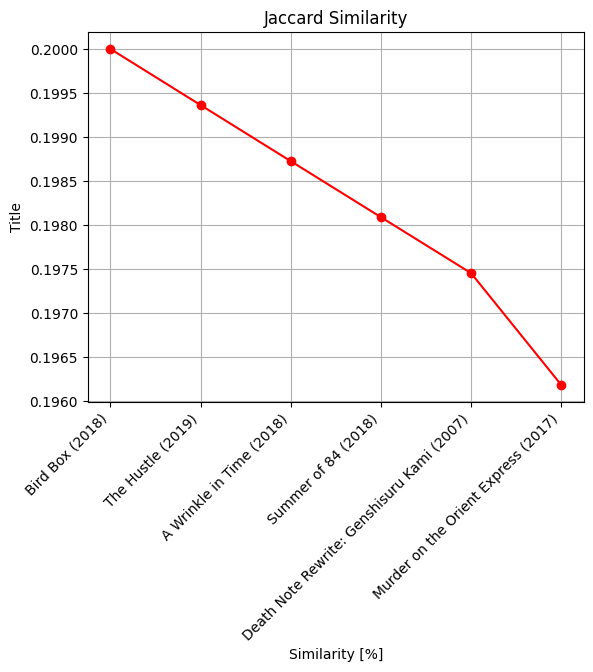

In [152]:
#Jaccard Distance
similar_movies_with_jaccard = get_top_tags_jaccard_sims(count, movies, query)
distances = GetPlotData(similar_movies_with_jaccard.items())

plt.grid()
plt.plot(distances[1], distances[0], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Jaccard Similarity")
plt.show()

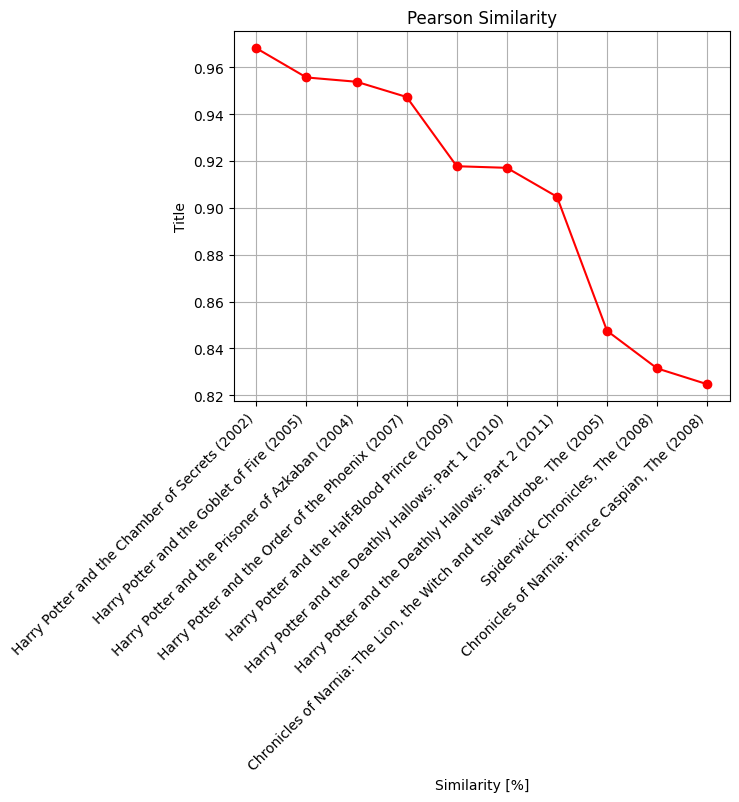

In [50]:
#Pearson Similarity
similarPearsonMovies = GetTopTagsPearsonCorrelation(count, movies, query)
similarities = GetPlotData(similarPearsonMovies.items())

plt.grid()
plt.plot(similarities[0], similarities[1], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Pearson Similarity")
plt.show()

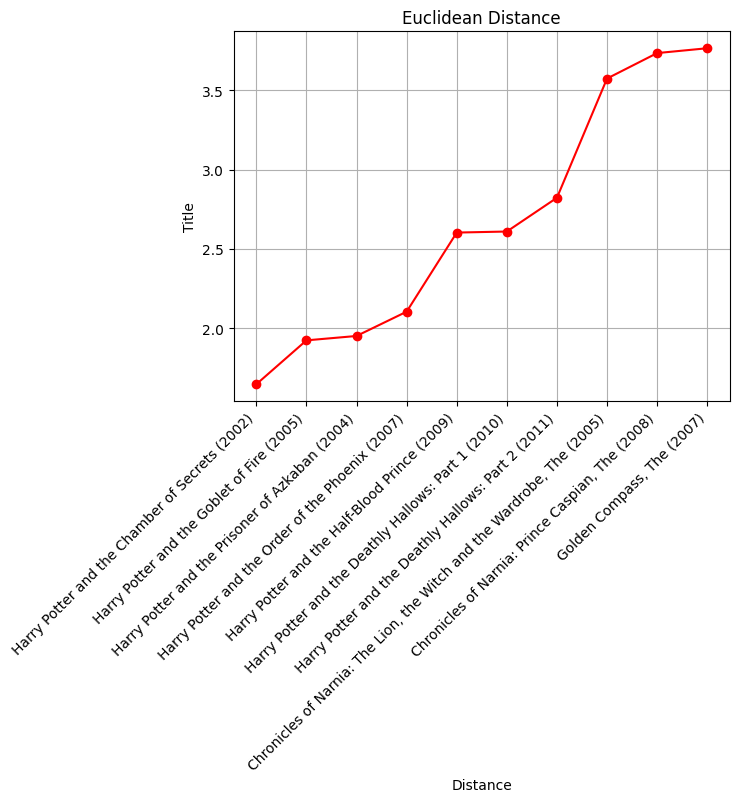

In [49]:
#Euclidean Distance
similarEuclideanDistanceMovies = GetTopTagsEuclideanDistance(count, movies, query)
distances = GetPlotData(similarEuclideanDistanceMovies)

plt.grid()
plt.plot(distances[0], distances[1], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Distance")
plt.ylabel("Title")
plt.title("Euclidean Distance")
plt.show()

# Fuzzy Title Matching - Levenshtein

Fuzzy matches the given title against all movie titles using the levenshtein distance

In [9]:
def fuzzyMatch(movies, user_title):
    movie_titles = [movies[mID].name for mID in movies]
    return process.extractOne(user_title, movie_titles, scorer=fuzz.partial_ratio)


def GetMovieByName(searchQuery):
    query = fuzzyMatch(movies, searchQuery)
    searchedMovie = movies[1]
    for movie in movies:
        if movies[movie].name == query[0]:
            searchedMovie = movies[movie]
            break
    return searchedMovie

matched_title = fuzzyMatch(movies, "Serch fo Spick")
print(matched_title)
print(GetMovieByName("pider human").name)

('Star Trek III: The Search for Spock (1984)', 79)
Spider-Man (2002)


# Fuzzy Title Matching - TF-IDF w. Cosine Similarity
Fuzzy matches the given title against all movies title using tf-idf and the cosine similarity measure

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def getTitleTokensTrigram(title):
    title = title.lower()
    return [title[idx] + title[idx + 1] + title[idx + 2] for idx in range(len(title) - 2)]

def getTitleTokensBigram(title):
    title = title.lower()
    return [title[idx] + title[idx + 1] for idx in range(len(title) - 1)]

def getAllDistinctTitleTokens(titles, getTitleTokens):
    title_tokens = set()
    for title in titles:
        title_tokens.update(getTitleTokens(title))
    return sorted(title_tokens)

def getTF(titles, title_tokens, getTitleTokens):
    tf_dict = dict.fromkeys(title_tokens, 0)
    for title in titles:
        for token in set(getTitleTokens(title)):
            tf_dict[token] += 1
    return tf_dict

def getIDF(termFrequencyDict, num_titles, title_tokens):
    idf_dict = dict.fromkeys(title_tokens, 0)
    for token in title_tokens:
        idf_dict[token] = np.log10(num_titles / (termFrequencyDict[token]))
    return idf_dict

def getTFIDF(title, title_tokens, idf_dict, getTitleTokens):
    tfidf_dict = dict.fromkeys(title_tokens, 0)
    for token in set(getTitleTokens(title)):
        tfidf_dict[token] += idf_dict[token]
    return tfidf_dict

def getMostSimilarTitles(similarty_dict, top_num):
    top_titles = dict()
    for key in sorted(similarty_dict, key=similarty_dict.get, reverse=True)[:top_num]:
        top_titles[key] = similarty_dict[key]
    return top_titles

def cosineSimilarity(vector1, vector2, getTitleTokens):
    d_1 = 0
    d_2 = 0
    numerator = 0
    for v1, v2 in zip(vector1, vector2):
        numerator += v1 * v2
        d_1 += v1 ** 2
        d_2 += v2 ** 2

    d1_euclid = np.sqrt(d_1)
    d2_euclid = np.sqrt(d_2)
    denominator = (d1_euclid * d2_euclid) if (d1_euclid * d2_euclid) >= 0 else -(d1_euclid * d2_euclid)
    return numerator / denominator
    

def fuzzyMatchTFIDF(user_title, titles, getTitleTokens, sim_cos=True):
    titles = set([movies[mID].name for mID in movies] + [user_title])
    title_tokens = getAllDistinctTitleTokens(titles, getTitleTokens)

    tf_dict = getTF(titles, title_tokens, getTitleTokens)
    idf_dict = getIDF(tf_dict, len(titles), title_tokens)
    
    user_title_dict = dict.fromkeys(title_tokens, 0)
    for token in getTitleTokens(user_title):
        user_title_dict[token] += idf_dict[token]

    current_title_dict = dict.fromkeys(title_tokens, 0)
    titles.remove(user_title)
    similarity_dict = dict()
    for title in titles:
        current_title_dict = getTFIDF(title, title_tokens, idf_dict, getTitleTokens)
        if sim_cos:
            similarity_dict[title] = cosine_similarity([list(current_title_dict.values())], [list(user_title_dict.values())])[0][0]
        else:
            similarity_dict[title], _ = pearsonr(list(current_title_dict.values()), list(user_title_dict.values()))
    return similarity_dict

#similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensBigram, true)
#top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
#print(top_similar_titles)
#similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensBigram, false)
#top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
#print(top_similar_titles)
#similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensTrigram, true)
#top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
#print(top_similar_titles)
#similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensTrigram, false)
#top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
#print(top_similar_titles)

#top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
#print(top_similar_titles)

In [11]:
import matplotlib.pyplot as plt

{'The Dead and the Living (2012)': 0.6918180301710853, 'The Living and the Dead (2007)': 0.6839787159198627, 'The Living End (1992)': 0.598357613790444, 'The Living (2014)': 0.5691442594878693, 'Assisted Living (2003)': 0.5687874636882185, 'Living and the Dead, The (2006)': 0.5632815955774064, 'Live and let Live (2013)': 0.5356307693631137, 'Man Divided (2017)': 0.52887712078424, 'Living (2012)': 0.5156786422677602, 'Heal the Living (2016)': 0.5070727970462446}


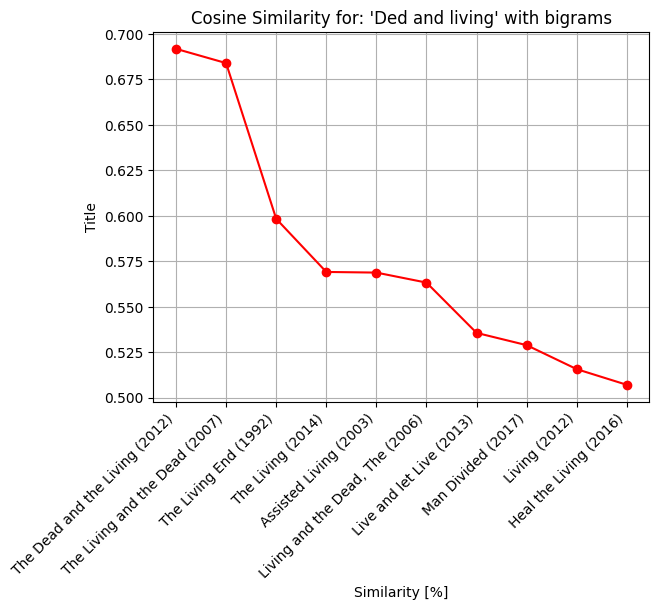

In [12]:
#cosine similarity and ngrams-size: 2

similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensBigram, True)
top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
print(top_similar_titles)

plt.grid()
plt.plot(top_similar_titles.keys(), top_similar_titles.values(), marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Cosine Similarity for: 'Ded and living' with bigrams")
plt.show()

{'The Dead and the Living (2012)': 0.5547627047268802, 'Assisted Living (2003)': 0.5118738973295116, 'The Living (2014)': 0.5112730083398669, 'Living (2012)': 0.4855360317368165, 'The Living and the Dead (2007)': 0.45796011095159395, 'The Living End (1992)': 0.41502650914087685, 'Stanley and Livingstone (1939)': 0.409922676777912, 'Last of the Living (2009)': 0.40636193138494414, 'Heal the Living (2016)': 0.40538999707364637, 'Among the Living (2014)': 0.4033871852574653}


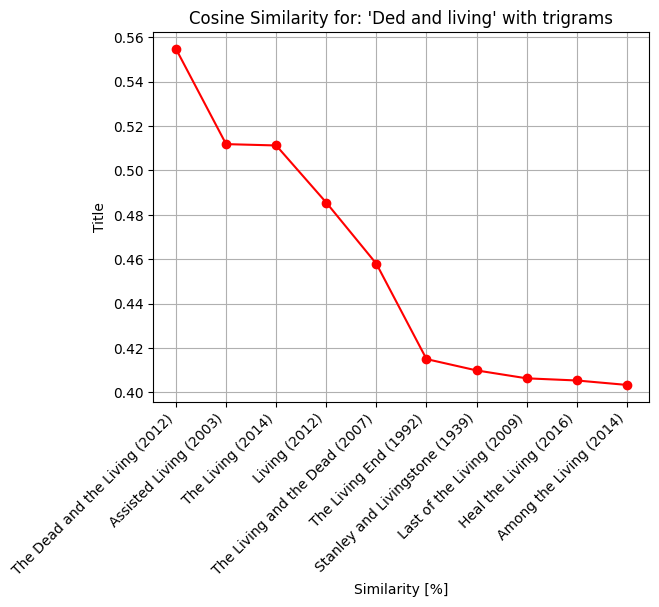

In [13]:
#cosine similarity and ngrams-size: 3

similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensTrigram, True)
top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
print(top_similar_titles)

plt.grid()
plt.plot(top_similar_titles.keys(), top_similar_titles.values(), marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Cosine Similarity for: 'Ded and living' with trigrams")
plt.show()

{'The Dead and the Living (2012)': 0.6905050977000935, 'The Living and the Dead (2007)': 0.6826264043123487, 'The Living End (1992)': 0.596716006525015, 'The Living (2014)': 0.5675871061487255, 'Assisted Living (2003)': 0.566945914562346, 'Living and the Dead, The (2006)': 0.5613318536959891, 'Live and let Live (2013)': 0.5337988291132328, 'Man Divided (2017)': 0.5270604274664009, 'Living (2012)': 0.5141619907079801, 'Heal the Living (2016)': 0.5050525523587085}


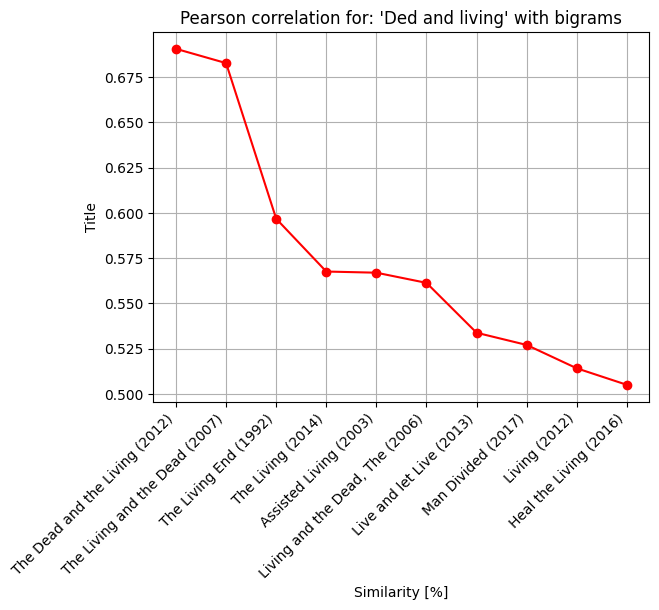

In [14]:
#pearson correlation and ngrams-size: 2

similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensBigram, False)
top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
print(top_similar_titles)

plt.grid()
plt.plot(top_similar_titles.keys(), top_similar_titles.values(), marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Pearson correlation for: 'Ded and living' with bigrams")
plt.show()

C:\Users\alexw\Desktop\jupyter\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'The Dead and the Living (2012)': 0.5544433705193571, 'Assisted Living (2003)': 0.5115464619540253, 'The Living (2014)': 0.5109977256149222, 'Living (2012)': 0.48528903519362143, 'The Living and the Dead (2007)': 0.4575612983894861, 'The Living End (1992)': 0.4146522205720971, 'Stanley and Livingstone (1939)': 0.40946970786826714, 'Last of the Living (2009)': 0.40594396291559853, 'Heal the Living (2016)': 0.40500224936877827, 'Among the Living (2014)': 0.40299754469965277}


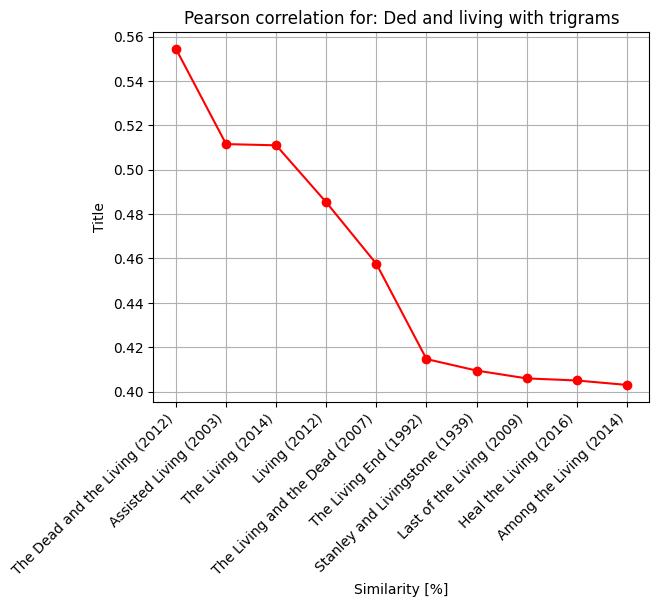

In [15]:
#pearson correlation and ngrams-size: 3

similarity_dict = fuzzyMatchTFIDF("Ded and living", movies, getTitleTokensTrigram, False)
top_similar_titles = getMostSimilarTitles(similarity_dict, 10)
print(top_similar_titles)

plt.grid()
plt.plot(top_similar_titles.keys(), top_similar_titles.values(), marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Pearson correlation for: Ded and living with trigrams")
plt.show()

# User Struct

A struct that contains the user ratings and also the tags the user choosed for a movie.

In [16]:
class User:
    def __init__(self, id):
        self.id = id
        self.movieRatings = {}
        self.movieTags = {}
        self.genomMovieTags = {}
    
    def AddRating(self, movie, rating):
        self.movieRatings[movie] = rating
    
    def AddTags(self, movie, tag):
        if movie not in self.movieTags:
            self.movieTags[movie] = []
        self.movieTags[movie].append(tag)

    def UpdateGenomTags(self, lookUpTableGenom):
        for movie in self.movieTags:
            inside = list()
            for tag in self.movieTags[movie]:
                for values in lookUpTags:
                    if lookUpTags[values] == tag:
                        inside.append(values)
                        
            self.genomMovieTags[movie] = inside


**Creates a list in User with every movie ranked by the User the calculates the generel movie ratings**

takes 5 minutes...

In [17]:
# userId,movieId,rating,timestamp
def CreateUsers(allMovies):
    ratings = pd.read_csv('ratings.csv')
    UserDic = {}
    userId = -1

    for i in range(len(ratings)):
        movie = allMovies[ratings['movieId'][i]]
        userID = ratings['userId'][i]
        ratingsRow = ratings['rating'][i]

        if userID != userId:
            userId = userID
            newUser = User(userId)      
            UserDic[newUser.id] = newUser

        newUser.AddRating(movie, ratingsRow)
        movie.AddRatingCount(ratingsRow)
    return UserDic

users = CreateUsers(movies)


In [18]:
# 7045,4896,4.0
print(movies[4896].name)
print("Movie Rating:", movies[4896].rating)
print("Random User Rating: ", users[7045].movieRatings[movies[4896]])


Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Movie Rating: 3.678158491145853
Random User Rating:  4.0


**Addind tags that user rated on movies (not every rated movie has a tag vice versa)**

In [19]:
#userId,movieId,tag,timestamp
def UserDefinedTag(allUsers, movies):
    userTags = pd.read_csv('tags.csv')

    activeUser = allUsers[userTags['userId'][0]]
    
    movie = movies[userTags['movieId'][0]]
    for i in range(len(userTags)):
        if activeUser.id != userTags['userId'][i]:
            activeUser = allUsers[userTags['userId'][i]]

        if movie.id != userTags['movieId'][i]:
            movie = movies[userTags['movieId'][i]]

        activeUser.AddTags(movie, userTags['tag'][i])
       
UserDefinedTag(users, movies) 


**Adding the Genom tags in numerical form**

In [20]:
def SetGenomTags(allUsers):
    for userId in allUsers:
        allUsers[userId].UpdateGenomTags(lookUpTags)

SetGenomTags(users)

**There are some Userdefined tags that arent in the 1128 tags** Example [Hayao Miyazaki,Miyazaki]

In [21]:
# print("Movie:", movies[7099].name)

def CheckIfInLoopUpTable(genresToCheck):
    inside = list()
    keys = []
    for item in genresToCheck:
        for values in lookUpTags:
            if lookUpTags[values] == item:
                inside.append(item)
                keys.append(values)

    outside = list(set(genresToCheck) - set(inside))
    print("Genres:", genresToCheck)
    print("Inside:", inside)
    print("Inside (numeric):", keys)
    print("Not inside:", outside)
    return inside

CheckIfInLoopUpTable(list(users[19].movieTags[movies[7099]]))
print("Genom Tags(inside):", users[19].genomMovieTags[movies[7099]])

Genres: ['adventure', 'anime', 'ecology', 'fantasy', 'Hayao Miyazaki', 'Miyazaki', 'post-apocalyptic']
Inside: ['adventure', 'anime', 'ecology', 'fantasy', 'post-apocalyptic']
Inside (numeric): [29, 65, 342, 377, 803]
Not inside: ['Hayao Miyazaki', 'Miyazaki']
Genom Tags(inside): [29, 65, 342, 377, 803]


Tags class and lookup table for tag name and id

In [113]:

class Tags:
    def __init__(self, tag_id, tag_name):
        self.tags_relevance = [0] * 1128
        self.tag_id = tag_id
        self.tag_name = tag_name

    def set_tag_relevance_vector(self, tags_relevance):
        self.tags_relevance = tags_relevance



def create_tag_list():
    tags_dict = {}
    genome_tags = pd.read_csv('genome-tags.csv')

    for i in range(len(genome_tags)):

        tag = Tags(genome_tags['tagId'][i], genome_tags['tag'][i])
        tags_dict[tag.tag_name] = tag

    return tags_dict


def create_tags_id_lookup_table():
    genres = pd.read_csv('genome-tags.csv')
    tags_lookup_table = {}
    for index in range(len(genres)):
        tags_lookup_table[genres['tag'][index]] = genres['tagId'][index]
        index += 1
    return tags_lookup_table


lookup_table_tags = create_tags_id_lookup_table()
tags_list = create_tag_list()




In [114]:
def user_tag_search(tags_test, movies, count):

    tags_counter_vector = [0] * 1128

    for tag in tags_test:
        tags_counter_vector[lookup_table_tags[tag]] = 1

    similar_movies = {}
    sim_values = []
    for mID in movies:
        if movies[mID].tagsRelevance.count(0) == 1128:
            continue
        sim = calc_cosine(movies[mID].tagsRelevance, tags_counter_vector)
        sim_values.append(sim)
        similar_movies[sim] = movies[mID].name

    top_similar = {}
    sim_values.sort(reverse=True)

    for i in range(count):
        top_similar[sim_values[i]] = similar_movies[sim_values[i]]
    return top_similar



User can use the function user_tag_search to insert genome tags and get movie recommendations as a result

In [117]:
user_tag_result = user_tag_search(["action", "action packed"], movies, 10)
PrintSimilarity(user_tag_result)

similar Movies: 
1 Chinese Zodiac (Armour of God III) (CZ12) (2012): 0.18733320883806595
2 Tom and Huck (1995): 0.17766026440448682
3 Patriot, The (1998): 0.1752875931207842
4 Three Musketeers, The (2011): 0.17522993506272752
5 Punisher, The (1989): 0.17487741593470277
6 Drop Zone (1994): 0.17060262204576068
7 Braddock: Missing in Action III (1988): 0.16947919499357886
8 Pinocchio (2002): 0.16857685215785298
9 Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985): 0.16717386334646753
10 Three Musketeers, The (1993): 0.16694866466481667


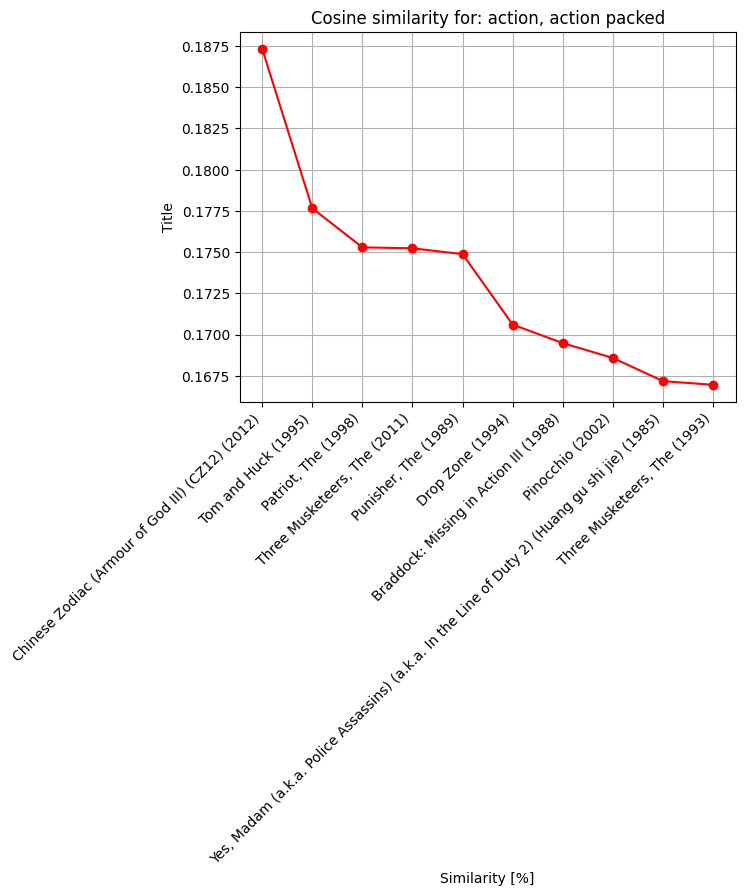

In [120]:
#Plot of user_tag_search
user_tag_result = user_tag_search(["action", "action packed"], movies, 10)
data = GetPlotData(user_tag_result.items())

plt.grid()
plt.plot(data[1], data[0], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Cosine similarity for: action, action packed")
plt.show()

**Getting top Movies rated movies in specified genre can set a min user rating counter**

In [25]:
def GetMoviesWithGenre(movies, querys):
    lenght = len(querys)
    queryIds = [lookUpTableGenres[item] for item in querys]
    moviesWithOnly = []
    skipMovie = False
    
    for movie in movies:
        for id in queryIds:
            if id not in movies[movie].genres or len(movies[movie].genres) != lenght:
                skipMovie = True
                break
        if not skipMovie:
            moviesWithOnly.append(movies[movie])
        skipMovie = False
    return moviesWithOnly


def GetHighestRanking(count, minRatingCount, genres):
    movie_titles = [key for key in lookUpTableGenres]

    queryGenre = []
    for genre in genres:
        titelSearch = process.extractOne(genre, movie_titles, scorer=fuzz.partial_ratio)
        if titelSearch[1] < 80:
            continue
        queryGenre.append(titelSearch[0])

    if len(queryGenre) == 0 or '(no genres listed)' in queryGenre:
        queryGenre = ['(no genres listed)']

    prestr = "["
    for index in range(len(queryGenre)):
        prestr += f"{queryGenre[index]}({lookUpTableGenres[queryGenre[index]]})"
        if index + 1 < len(queryGenre):
            prestr += ", "
    prestr += "]"

    print(f"Searching for the {count} best {prestr} movies with at least {minRatingCount} User-ratings:")
    simGenreMovies = GetMoviesWithGenre(movies, queryGenre)
    allRankings = {}
    ratingsList = []

    for movie in simGenreMovies:
        if movie.ratingCount < minRatingCount:
            continue
        if movie.rating not in allRankings:
            allRankings[movie.rating] = []
            if movie.rating not in ratingsList:
                ratingsList.append(movie.rating)
        allRankings[movie.rating].append(movie)

    ratingsList.sort(reverse=True)
    returnRanking = []
    while len(returnRanking) < count and len(ratingsList) != 0:
        value = max(ratingsList)
        index = 0
        for movie in allRankings[value]:
            index += 1
            # print(movie.name)
            returnRanking.append(movie)
            if len(returnRanking) >= count:
                break
        ratingsList.remove(value)       

    return returnRanking

def getGenreID(name):
    for id in lookUpTableGenres:
        if name == lookUpTableGenres[id]:
            return id
    return -1


Insert a num of max ranking and then add how many user rantings the movie must at least have and the genres

In [155]:
movieRanked = GetHighestRanking(10, 10, ['fantay' , 'harror', 'come'])

index = 1
for item in movieRanked:
    print(f"{index}. Titel: {item.name} | Users: {item.ratingCount} | Genres: {item.genres} | Rating {item.rating:.2f}")
    index += 1


Searching for the 10 best [Fantasy(5), Horror(11), Comedy(4)] movies with at least 10 User-ratings:
Searching for the 10 best [Horror(11)] movies with at least 10 User-ratings:
1. Titel: Shining, The (1980) | Users: 29931 | Genres: [11] | Rating 4.03
2. Titel: Get Out (2017) | Users: 5010 | Genres: [11] | Rating 3.96
3. Titel: Don't Hug Me, I'm Scared II: Time (2014) | Users: 66 | Genres: [11] | Rating 3.88
4. Titel: Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922) | Users: 3968 | Genres: [11] | Rating 3.88
5. Titel: Kwaidan (Kaidan) (1964) | Users: 415 | Genres: [11] | Rating 3.83
6. Titel: Michael Jackson's Thriller (1983) | Users: 16 | Genres: [11] | Rating 3.78
7. Titel: Eyes Without a Face (Yeux sans visage, Les) (1959) | Users: 615 | Genres: [11] | Rating 3.73
8. Titel: Don't Hug Me I'm Scared 5 (2015) | Users: 45 | Genres: [11] | Rating 3.73
9. Titel: Doctor Sleep (2019) | Users: 39 | Genres: [11] | Rating 3.73
10. Titel: Nosferatu the Vampyre (Nosferatu: Phantom der Nac

Searching for the 10 best [Horror(11), Fantasy(5)] movies with at least 10 User-ratings:


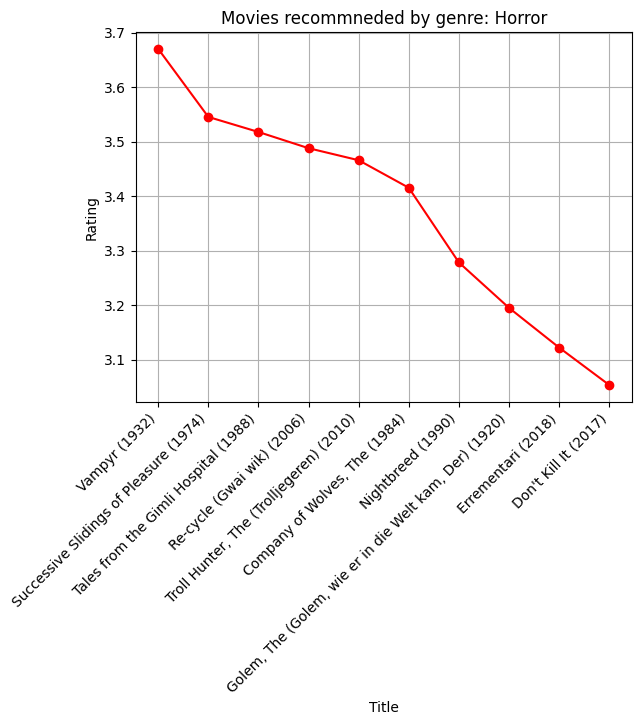

In [166]:
#Plot
movieRanked = GetHighestRanking(10, 10, ['harror', 'fantisy'])
namingList = [movie.name for movie in movieRanked]
ratingList = [movie.rating for movie in movieRanked]

plt.grid()
plt.plot(namingList, ratingList, marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Title")
plt.ylabel("Rating")
plt.title("Movies recommneded by genre: Horror")
plt.show()

**Adds the User tags to the Movies**

In [149]:

def create_movie_id_tags_lookup_table():
    tags = pd.read_csv('tags.csv')
    tags_lookup_table = {}
    movie_ids_set = set()
    movie_id = -1
    for index in range(len(tags)):

        if tags['movieId'][index] != movie_id and tags['movieId'][index] not in movie_ids_set:
            tags_lookup_table[tags['movieId'][index]] = []
            movie_id = tags['movieId'][index]
        movie_ids_set.add(movie_id)
        tags_lookup_table[tags['movieId'][index]].append(tags['tag'][index])

    return tags_lookup_table


lookup_table_tags = create_movie_id_tags_lookup_table()


**Similarity between movies using Jaccard similarity with the User Tags**

In [150]:
def get_top_tags_jaccard_sims_with_user_tags(count, movies, query):
    smiliar_movies = {}
    sim_values = []
    for mID in movies:
        if movies[mID].name == query.name:
            continue
        if mID not in lookup_table_tags or query.id not in lookup_table_tags:
            continue

        sim = jaccard_sim(lookup_table_tags[mID], lookup_table_tags[query.id])
        sim_values.append(sim)
        smiliar_movies[sim] = movies[mID].name

    top_similar = {}

    sim_values.sort(reverse=True)

    for i in range(count):
        top_similar[sim_values[i]] = smiliar_movies[sim_values[i]]
    return top_similar

count = 10
query = movies[4896] #harry potter
similar_movies_with_jaccard = get_top_tags_jaccard_sims_with_user_tags(count, movies, query)
PrintSimilarity(similar_movies_with_jaccard)

similar Movies: 
1 Harry Potter and the Chamber of Secrets (2002): 0.045366795366795366
2 Harry Potter and the Prisoner of Azkaban (2004): 0.04158790170132325
3 Harry Potter and the Goblet of Fire (2005): 0.04102096627164995
4 Harry Potter and the Order of the Phoenix (2007): 0.034129692832764506
5 Harry Potter and the Half-Blood Prince (2009): 0.03195488721804511
6 Harry Potter and the Deathly Hallows: Part 1 (2010): 0.02683982683982684
7 Harry Potter and the Deathly Hallows: Part 2 (2011): 0.022222222222222223
8 NeverEnding Story, The (1984): 0.020169851380042462
9 Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005): 0.01876172607879925
10 Peter Pan (1953): 0.015068493150684932


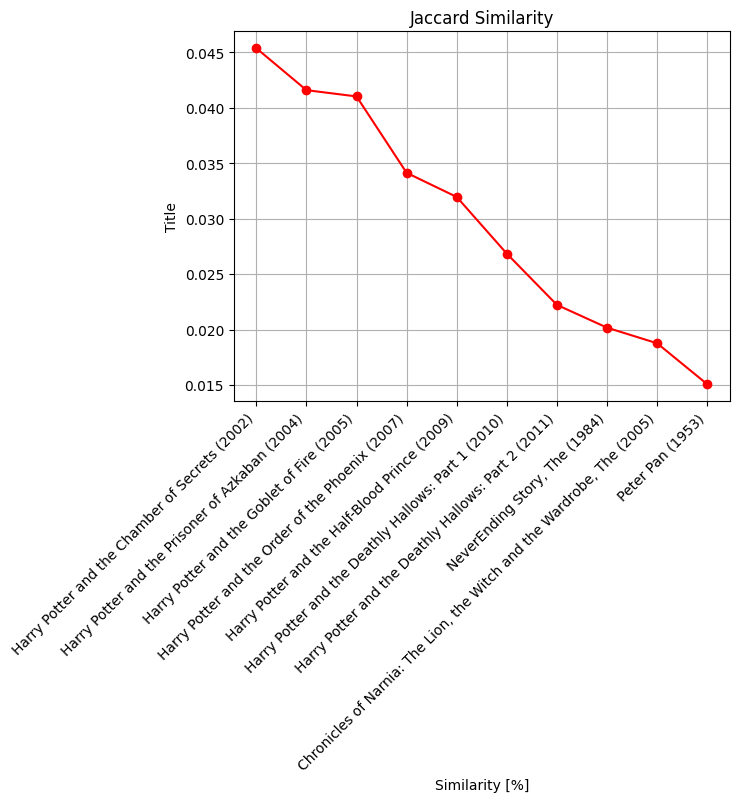

In [151]:
#Jaccard Distance
similar_movies_with_jaccard = get_top_tags_jaccard_sims_with_user_tags(count, movies, query)
distances = GetPlotData(similar_movies_with_jaccard.items())

plt.grid()
plt.plot(distances[1], distances[0], marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Similarity [%]")
plt.ylabel("Title")
plt.title("Jaccard Similarity")
plt.show()

#Movie Recommendation with collabrative filters

user-based collaborative filter 

In [180]:
def calculateUserSimilarityWithRatings(user1, user2):
    commonItems = set(user1.movieRatings.keys()) & set(user2.movieRatings.keys())

    user1Ratings = np.array([user1.movieRatings[item] for item in commonItems])
    user2Ratings = np.array([user2.movieRatings[item] for item in commonItems])

    dotProduct = np.dot(user1Ratings, user2Ratings)
    normalizedUser1 = np.linalg.norm(user1Ratings)
    normalizedUser2 = np.linalg.norm(user2Ratings)

    if normalizedUser1 == 0 or normalizedUser2 == 0:
        return 0
    elif np.isnan(dotProduct) or np.isnan(normalizedUser1) or np.isnan(normalizedUser2):
        return 0
    else:
      return dotProduct / (normalizedUser1 * normalizedUser2)

def userBasedCollaborativeFilter(user, users, numRecommendations):
  recommendations = []

  userSimilarities = [(otherUser, calculateUserSimilarityWithRatings(user, users[otherUser])) for otherUser in users if otherUser != user]

  userSimilarities.sort(key=lambda x: x[1], reverse=True)

  ratingsSum  = defaultdict(int)
  ratingsCount = defaultdict(int)

  for (other_userId, similarity) in userSimilarities [:numRecommendations]:
    otherUser = users[other_userId]

    for (item, rating) in otherUser.movieRatings.items():
      if item not in user.movieRatings:
        ratingsSum [item] += rating * similarity
        ratingsCount[item] += similarity

  itemAverages = [(item, ratingsSum [item] / ratingsCount[item]) for item in ratingsSum ]
  itemAverages.sort(key=lambda x: x[1], reverse=True)
  recommendations = [item for (item, average) in itemAverages]

  return recommendations

def predictRating(user, item, count):
  userSimilarities = [(otherUser, calculateUserSimilarityWithRatings(user, users[otherUser])) for otherUser in users if otherUser != user]

  userSimilarities.sort(key=lambda x: x[1], reverse=True)

  ratingsSum = 0
  ratingsCount = 0

  for (otherUserId, similarity) in userSimilarities[:count]:
    otherUser = users[otherUserId]

    if item in otherUser.movieRatings:
      ratingsSum += otherUser.movieRatings[item] * similarity
      ratingsCount += similarity

  return ratingsSum / ratingsCount if ratingsCount > 0 else 0

Output

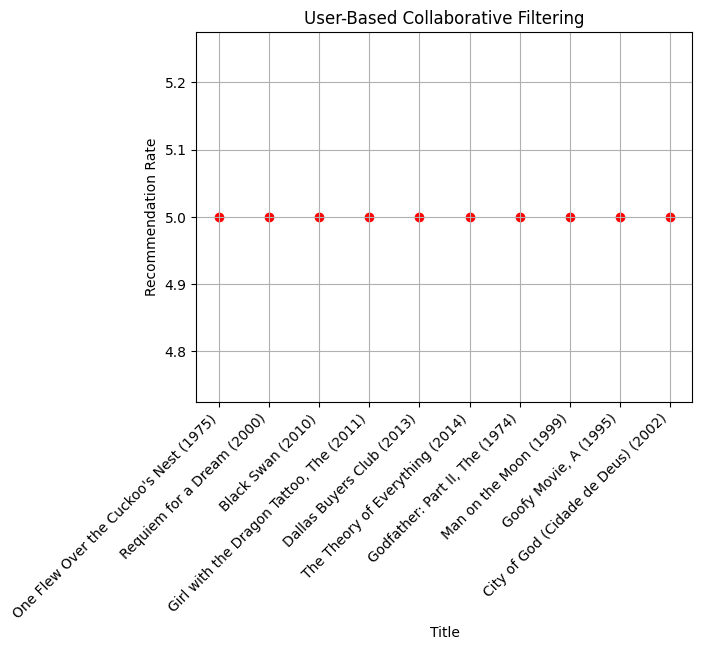

In [188]:
user = users[7045]
count = 10

print("\nRecommendations with user-based collaborative filters: \n")
recommendations = userBasedCollaborativeFilter(user, users, count)
for movie in recommendations[:count]:
  print(movie.name)


#Plot
recommendedMovies = userBasedCollaborativeFilter(user, users, count)
recommendationRates = [predictRating(user, movies[movieId.id], count) for movieId in recommendedMovies[:count]]
recommendedMovieNames = [movie.name for movie in recommendedMovies]

plt.grid()
plt.scatter(recommendedMovieNames[:count], recommendationRates, marker='o', color="r")
plt.xticks(ha='right', rotation=45)
plt.xlabel("Title")
plt.ylabel("Recommendation Rate")
plt.title("User-Based Collaborative Filtering")
plt.show()